In [63]:
import numpy as np 
import matplotlib.pyplot as plt

# Beamforming and DoA estimation

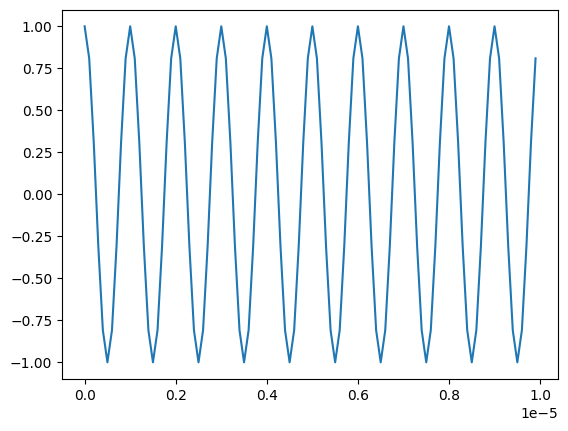

In [64]:
# Generating a TX signal 
A=1
f=1e6                           #Downconverted frequncy
fs = 10*f                       #sampling frequency 
td = 10e-3                      #duration of the signal 
samples = int(fs*td)            #number of samples 
t = np.linspace(0, td, samples) #time vector

tx = A*np.exp(1j*2*np.pi*f*t)   
n = np.random.normal(0, 0.1, np.shape(tx)) + 1j*np.random.normal(0, 0.1, np.shape(tx))  # zero mean, 0.1 std complex noise
txn = np.array([tx + 0])                    # noisy signal 

plt.plot(t[0:100], np.real(txn[0,0:100]))

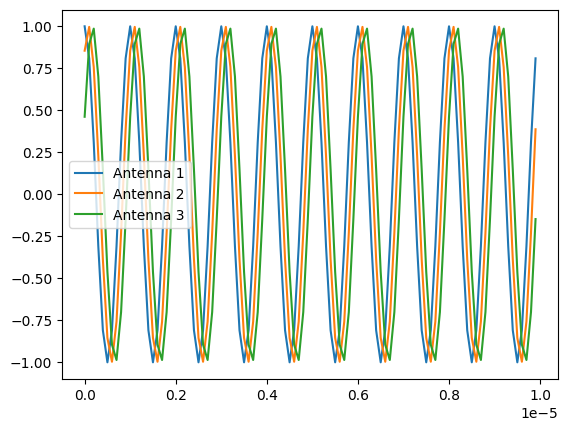

In [65]:
# Generating the RX signal 
d = 0.5 #inter-element spacing (actually d/lamba)
angle = 10 #degrees
angle_rad = (angle/180)*np.pi

#steering vector for a 3-element antenna array
steering_vec = np.array([[1,
                np.exp(-1j*2*np.pi*d*np.sin(angle_rad)), 
                np.exp(-1j*2*np.pi*2*d*np.sin(angle_rad))]])

rx = steering_vec.T * txn 
n_rx = n = np.random.normal(0, 0.1, np.shape(rx)) + 1j*np.random.normal(0, 0.1, np.shape(rx))  #noise at the receiver 

rxn = rx + 0 #+ n_rx   #Noisy receiver signal

plt.plot(t[0:100], np.real(rxn[0, 0:100]), label="Antenna 1") #antenna 1 
plt.plot(t[0:100], np.real(rxn[1, 0:100]), label="Antenna 2") #antenna 2
plt.plot(t[0:100], np.real(rxn[2, 0:100]), label="Antenna 3") #antenna 3
plt.legend()

In the above plot, we can check out the initial phases of the three different antennas in the array, which are increasing from 1 --> 2 --> 3.  

In [66]:
# Beamforming - Delay and Sum beamformer 
results = []
radar_fov = 90 # -45 degrees to +45 degrees
radar_fov_intervals = (np.linspace(-45, 45, 180))/180*np.pi   #0.5 degree resolution

# Go over all angles to find the best
for i in radar_fov_intervals:
    s = np.array([[1,
                np.exp(-1j*2*np.pi*d*np.sin(i)), 
                np.exp(-1j*2*np.pi*2*d*np.sin(i))]])
    
    # Hermitian of the steering vector = steering_vec.conj().T 
    ds_bf = s.conj().T * rxn
    results.append(np.mean(ds_bf**2))  #store the power 


In [67]:
# DOA finding 
DOA_idx = np.argmax(np.abs(results))
DOA = radar_fov_intervals[DOA_idx]*180/np.pi
print(DOA)

9.804469273743017


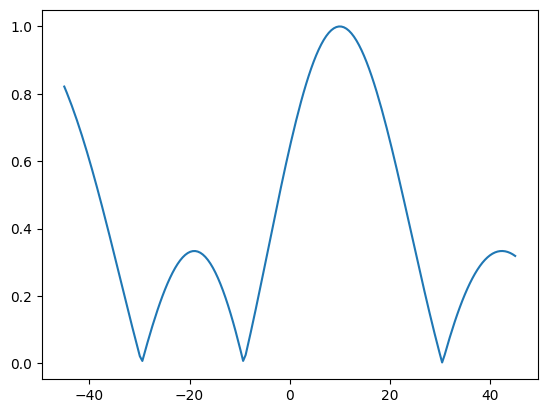

In [68]:
plt.plot(radar_fov_intervals*180/np.pi, np.abs(results)/np.max(np.abs(results)))

In [ ]:
# Delay and Sum beamforming -- Very much impacted by the noise
# In the edge cases, an opposite peak might be formed on the negative angle, giving a wrong estimation 
# Lobes are very wide --> discerning multiple targets might be a problem 

# MUSIC 

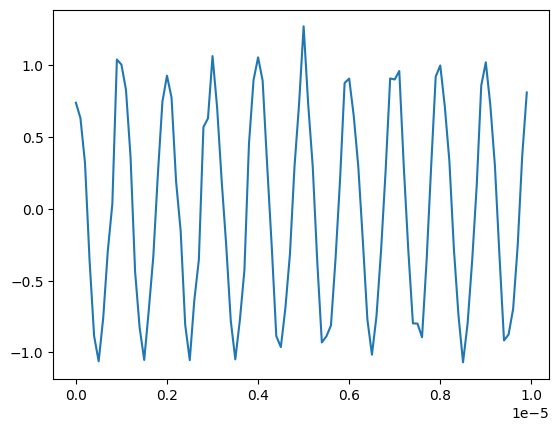

In [73]:
# Generating a TX signal 
A=1
f=1e6                           #Downconverted frequncy
fs = 10*f                       #sampling frequency 
td = 10e-3                      #duration of the signal 
samples = 5000           #number of samples 
t = np.arange(samples)/fs #time vector

tx = A*np.exp(1j*2*np.pi*f*t)   
n = np.random.normal(0, 0.1, np.shape(tx)) + 1j*np.random.normal(0, 0.1, np.shape(tx))  # zero mean, 0.1 std complex noise
txn = np.array([tx + n])                    # noisy signal 

plt.plot(t[0:100], np.real(txn[0,0:100]))

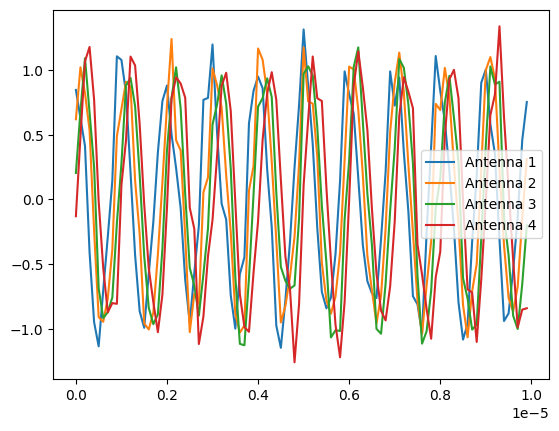

In [75]:
# Generating the RX signal 
d = 0.5 #inter-element spacing (actually d/lamba)
angle = 10 #degrees
angle_rad = (angle/180)*np.pi

#steering vector for a 3-element antenna array
steering_vec = np.array([[1,
                np.exp(-1j*2*np.pi*d*np.sin(angle_rad)), 
                np.exp(-1j*2*np.pi*2*d*np.sin(angle_rad)), 
                np.exp(-1j*2*np.pi*3*d*np.sin(angle_rad))]])

rx = steering_vec.T * txn 
n_rx = n = np.random.normal(0, 0.1, np.shape(rx)) + 1j*np.random.normal(0, 0.1, np.shape(rx))  #noise at the receiver 

rxn = rx + n_rx #+ n_rx   #Noisy receiver signal

plt.plot(t[0:100], np.real(rxn[0, 0:100]), label="Antenna 1") #antenna 1 
plt.plot(t[0:100], np.real(rxn[1, 0:100]), label="Antenna 2") #antenna 2
plt.plot(t[0:100], np.real(rxn[2, 0:100]), label="Antenna 3") #antenna 3
plt.plot(t[0:100], np.real(rxn[3, 0:100]), label="Antenna 4") #antenna 4
plt.legend()

In [76]:
# Generate the convariance matrix 
Rxx = np.cov(rxn)

In [78]:
np.real(Rxx)

array([[ 1.03990015,  0.87140789,  0.46987764, -0.06694982],
       [ 0.87140789,  1.03922161,  0.86916579,  0.4702217 ],
       [ 0.46987764,  0.86916579,  1.03383908,  0.86901003],
       [-0.06694982,  0.4702217 ,  0.86901003,  1.03925348]])

In [ ]:
# Calculate eigenvalues and eigenvectors of the cov matrix
[evalues, evectors] = np.linalg.eig(Rxx)

np.real(evalues) # only one eigenvalue is high (one target)

array([4.09266041, 0.02052342, 0.01980029, 0.0192302 ])

In [84]:
threshold = 1 # eigenvalue > 1 --> target, o/w noise (empirical)

n_targets = np.count_nonzero(np.real(evalues) > threshold)
n_noise_eigvals = np.count_nonzero(np.real(evalues) < threshold)

NOTE: For M antenna elements, the array can resolve at most M-1 targets

In [88]:
# Sort the eigenvectors in the eigenvalue order 
print(np.argsort(evalues))

evectors_sorted = evectors[:, np.argsort(evalues)]

[3 2 1 0]


In [89]:
np.real(evectors_sorted)

array([[-0.0737617 ,  0.65432685, -0.44958365,  0.50042018],
       [ 0.02776522,  0.01051434,  0.65634999,  0.42767571],
       [ 0.74218761, -0.12400987, -0.2298196 ,  0.23051962],
       [-0.11369844, -0.1261041 , -0.24790126, -0.03294182]])

In [92]:
# generate the noise subspace
Qn = evectors_sorted[0:, 0:n_noise_eigvals]

np.real(Qn)

array([[-0.0737617 ,  0.65432685, -0.44958365],
       [ 0.02776522,  0.01051434,  0.65634999],
       [ 0.74218761, -0.12400987, -0.2298196 ],
       [-0.11369844, -0.1261041 , -0.24790126]])

$$ \theta_{MUSIC} = \argmax_{\theta} \frac{1}{s(\theta)^H Q_n Q_n^H s(\theta)}  $$

where $s(\theta)$ is the steering vector at angle $\theta$ and $Q_n$ is the noise subspace of the received covariance matrix. 

In [104]:
results = []
radar_fov = 90 # -45 degrees to +45 degrees
radar_fov_intervals = (np.linspace(-45, 45, 180))/180*np.pi   #0.5 degree resolution

# Go over all angles to find the best
for i in radar_fov_intervals:
    s = np.array([[1,
                    np.exp(-1j*2*np.pi*d*np.sin(i)), 
                    np.exp(-1j*2*np.pi*2*d*np.sin(i)), 
                    np.exp(-1j*2*np.pi*3*d*np.sin(i))]])
    
    # print(np.shape(s.conj()))
    # print(np.shape(Qn))
    # print(np.shape(Qn.conj().T))
    # print(np.shape(s.T))

    theta_music = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T)   # MUSIC spectrum formula 
    theta_music_db = 10*np.log10(np.abs(theta_music))       # convert to db
    results.append(theta_music_db[0])


In [109]:
# AOA finding 
AOA_idx = np.argmax(np.abs(results))
AOA = radar_fov_intervals[AOA_idx]*180/np.pi
print(AOA)

9.804469273743017


([<matplotlib.axis.XTick at 0x7f299b3bdd00>,
 [Text(-40, 0, '−40'),
  Text(-30, 0, '−30'),
  Text(-20, 0, '−20'),
  Text(-10, 0, '−10'),
  Text(0, 0, '0'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40')])

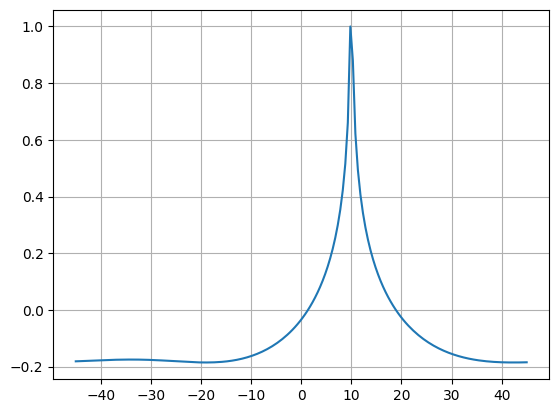

In [115]:
plt.plot(radar_fov_intervals*180/np.pi, results/np.max(results))
plt.grid()
plt.xticks([-40, -30, -20, -10, 0, 10, 20, 30, 40])